In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

from dataclasses import dataclass
from torch.autograd import Variable
import numpy as np

import math
import torch.optim as optim
import gym
import random
import matplotlib.pyplot as plt

## REINFORCE 

In [2]:
class policy_model(nn.Module): 
    
    def __init__(self): 
        super(policy_model, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(8, 256), 
            nn.ReLU(), 
            nn.Linear(256, 256), 
            nn.ReLU(), 
            nn.Linear(256, 256), 
            nn.ReLU(),
            nn.Linear(256, 4)
        )        
        
    def forward(self, data): 
        x = self.layers(data)
        return F.softmax(x, dim=1)

In [3]:
def REINFORCE(model, optimizer, render=False):
    
    all_rewards = []
    
    for episode in range(5000):
        state = env.reset()
        log_probs = []
        rewards = []
        GAMMA = 0.9
        print(episode)
        
        for steps in range(1000):
            if(render):
                env.render()
            
            state = torch.from_numpy(state).float().unsqueeze(0)
            
            probs = model(Variable(state))
            
            action = np.random.choice(4, p=np.squeeze(probs.detach().numpy()))
            
            log_prob = torch.log(probs.squeeze(0)[action])
            
            new_state, reward, done, _ = env.step(action)
            
            log_probs.append(log_prob)
            
            rewards.append(reward)
            
            if done:
                c = []
                for t in range(len(rewards)):
                    Gt = 0
                    for i, r in enumerate(rewards[t:]):
                        Gt = Gt + (GAMMA**(i+1)) * r
                    c.append(Gt)
      
                c = torch.tensor(c)    
                c = (c - c.mean()) / (c.std() + 1e-9)
            
                policy_gradient = []
                for log_prob, Gt in zip(log_probs, c):
                    policy_gradient.append(-log_prob * Gt)
    
                optimizer.zero_grad()
                torch.stack(policy_gradient).sum().backward()
                optimizer.step()
                break
                
            state = new_state

In [4]:
model = policy_model()
optimizer = optim.SGD(model.parameters() ,lr = 0.001)

In [5]:
REINFORCE(model, optimizer, render=False)

NameError: name 'env' is not defined

In [ ]:
REINFORCE(model, optimizer, render=False)

## DQN

### TODO: Still not correct

In [6]:
env = gym.make('CartPole-v0')

In [12]:
class DQN(nn.Module): 
    def __init__(self, input_dim, hidden_dim, output_dim): 
        super(DQN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )        
        
    def forward(self, data): 
        x = self.layers(data)
        return F.softmax(x, dim=0)

In [13]:
class Buffer: 
    
    mem = []
    
    def __init__(self, length): 
        self.length = length
        
    def add(self, observation):
        self.mem.append(observation)
        if len(self.mem) > self.length:
            self.mem = self.mem[-self.length:]
    
    def __len__(self): 
        return len(self.mem)

    def __iter__(self): 
        for k in self.mem: 
            yield k
            
    def sample(self, batch_size = 32):
        return random.sample(self.mem, batch_size)

In [29]:
class Agent: 
    
    def __init__(self, model, target, epsilon, e_decay, optimizer, epsilon_bound = 0.01, decay_frequency = 0.5, gamma = 0.9):
        self.model_base = model
        self.model_target = target
        self.model_target.load_state_dict(model_base.state_dict())
        self.epsilon = epsilon
        self.e_decay = e_decay
        self.epsilon_bound = epsilon_bound
        self.optimizer = optimizer
        self.decay_frequency = decay_frequency
        self.gamma = gamma

    def act(self, state): 
        if random.uniform(0, 1) < self.epsilon:
            return torch.tensor([[random.randrange(2)]], dtype=torch.long)
        else:
            with torch.no_grad():
                log_probs = self.model_base(torch.from_numpy(state).unsqueeze(0).float())
                action = torch.multinomial(log_probs, num_samples=1)
                return action
                
    def update_network(self):
        self.model_target.load_state_dict(model_base.state_dict())
        
    def train(self, batch):
        
        states = torch.tensor([item[0] for item in batch], dtype=torch.float32)
        actions =  torch.tensor([item[1] for item in batch], dtype=torch.int64)
        rewards = torch.tensor([item[2] for item in batch], dtype=torch.float32)
        next_states = torch.tensor([item[3] for item in batch], dtype=torch.float32)
        
        q_outputs = self.model_base(states).gather(1, actions.unsqueeze(0))
        q_targets = rewards + self.model_target(next_states).max(1)[0] * self.gamma
        
        loss = F.smooth_l1_loss(q_outputs, q_targets)
        
        optimizer.zero_grad()
        loss.backward()
        for param in model_base.parameters():
            param.grad.data.clamp_(-1, 1)
        optimizer.step()
        
    def decay(self): 
        tmp_epsilon = self.epsilon * self.e_decay
        if self.epsilon_bound < tmp_epsilon: 
            self.epsilon = tmp_epsilon

In [30]:
in_dim = env.observation_space.shape[0]
action = env.action_space.n    

model_base = DQN(in_dim, 250, action)
model_target = DQN(in_dim, 250, action)

optimizer = torch.optim.SGD(model_base.parameters(), lr = 0.001)
agent = Agent(model_base, model_target, 0.2, 0.99, optimizer, 0.01)

<ipython-input-29-6d96e4882163>:37: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([1, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(q_outputs, q_targets)


tensor([[1]])
tensor([[0]])
tensor([[1]])
tensor([[0]])
tensor([[1]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[1]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[1]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor

tensor([[1]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[1]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[0]])
tensor([[1]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[1]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[0]])
tensor([[1]])
tensor([[0]])
tensor([[0]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[1]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[1]])
tensor([[0]])
tensor([[1]])
tensor([[1]])
tensor

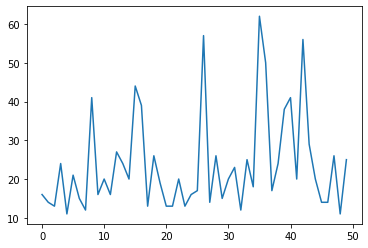

In [31]:
buffer = Buffer(1000)
batch_size = 32
s = env.reset()

episodes = 50
max_length_episode = 501

rewards = []

for i in range(episodes): 

    episode_rewards = []

    if i % 10 == 0:
        agent.update_network()

    for j in range(max_length_episode): 

        a = agent.act(s)
        if(len(buffer) >= batch_size):
            agent.train(buffer.sample(batch_size))

        s1, r, done, _ = env.step(a.item())
        buffer.add([s, a, r, s1])
        episode_rewards.append(r)
        s = s1

        if done:
            s = env.reset()
            rewards.append(np.array(episode_rewards).sum())
            break
        
plt.plot(rewards)

## Run

In [ ]:
import time

try:
    s = env.reset()
    for _ in range(50000):
        env.render()
        time.sleep(.01)
        a = agent.act(s)
        s, r, done, _ = env.step(a)
        if done:
            env.reset()
except KeyboardInterrupt:
    env.close()
    pass